In [17]:
import sys
sys.path.append('../')
import potentials


In [18]:
import numpy as np
import cv2
from sksparse.cholmod import cholesky
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import pandas as pd
from itertools import product as prod
import proplot as pplt
from scipy.special import expit
from tqdm import tqdm
import itertools as it
import scipy
from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys
import networkx as nx
from utils import inv_perm

nr, nc = 128, 256
ksize = 13

np.random.seed(110104)
plt.rc("text", usetex=True)

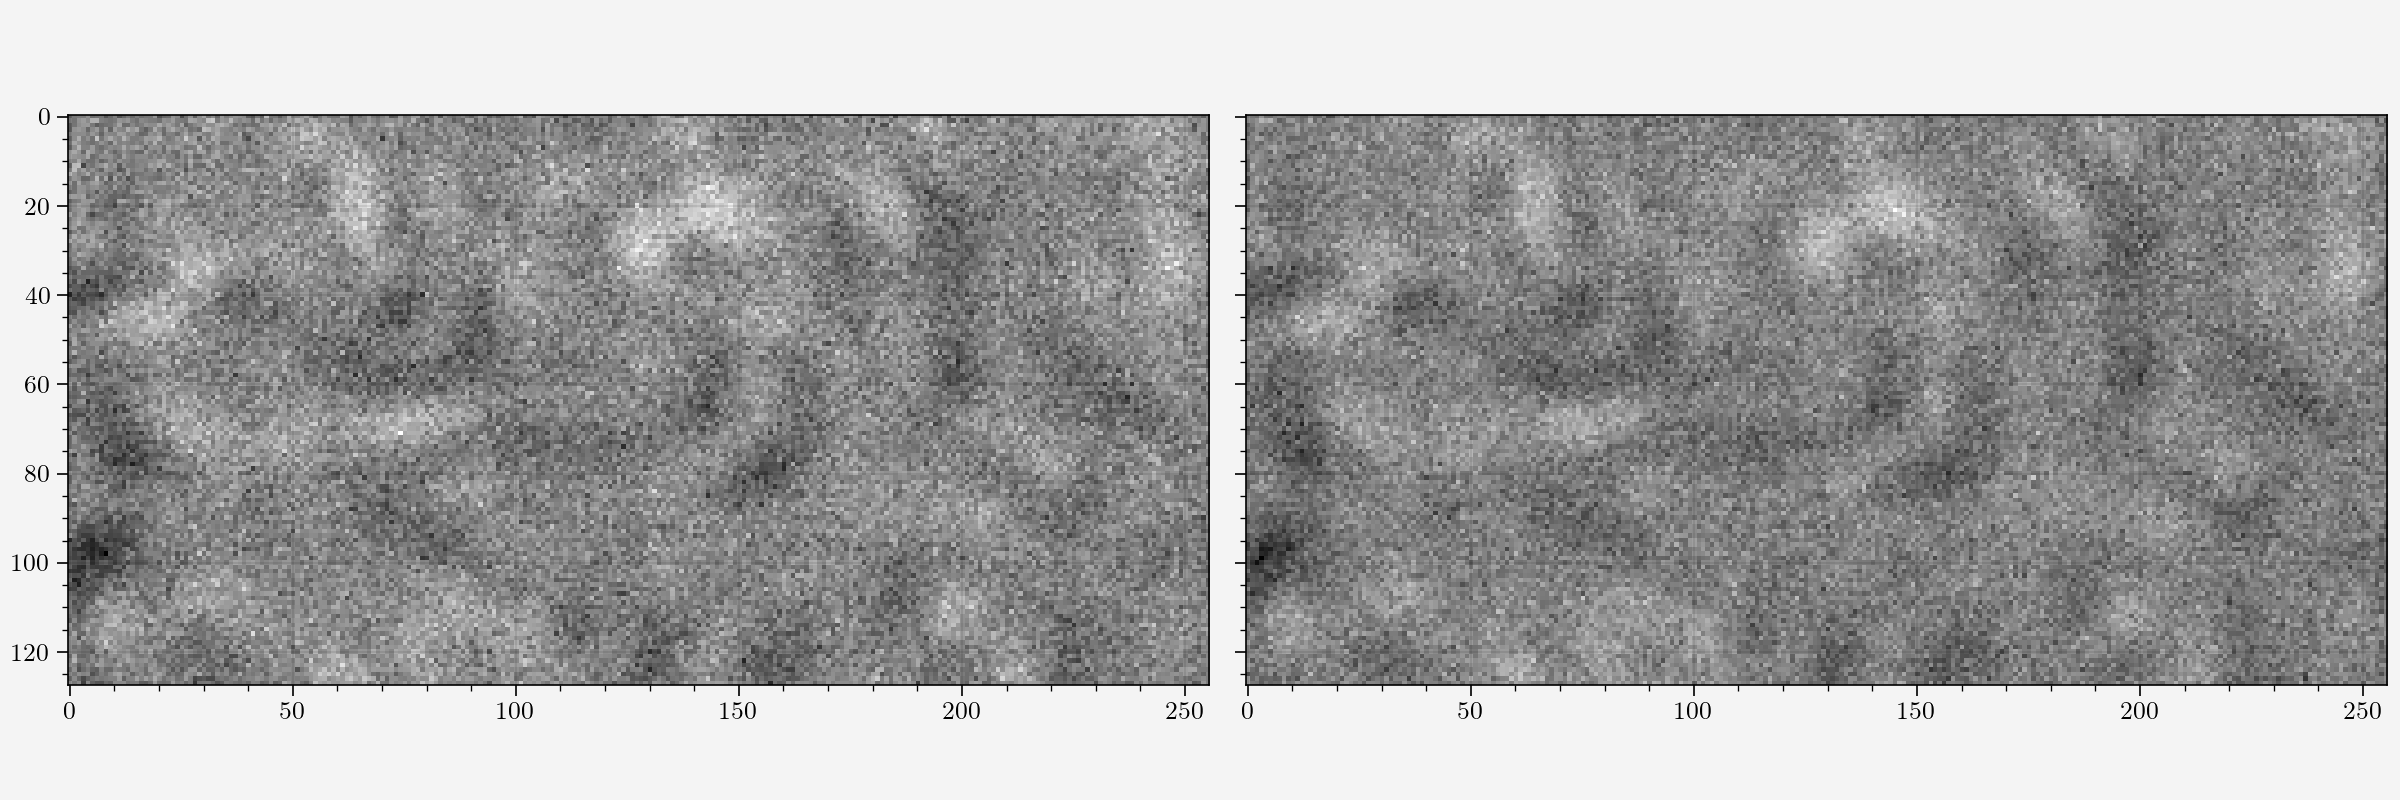

In [19]:
X1, X2, *_ = potentials.potential_features(nr, nc, ksize)
nt = 30
X1 = np.stack([X1 * np.exp(0.01 * np.sin(t)) for t in range(nt)], axis=0)
X2 = np.stack([X2 * np.exp(0.01 * np.cos(t)) for t in range(nt)], axis=0)
beta1, beta2, *_ = potentials.potential_features(nr, nc, ksize)
X = np.stack([X1, X2], axis=1)
beta = np.stack([beta1, beta2])
Ytrue = np.einsum('tijk,ijk->tjk', X, beta)

seff = 0.01 * np.sin(2 * np.pi * np.linspace(0, nt - 1, 5) / nt)
seff = seff[np.arange(nt) % 5]
teff = 0.01 * np.arange(nt) ** (3/4)
Y = Ytrue + (seff + teff)[:, None, None] + 0.01 * np.random.normal(0, 1, (nt, nr, nc))
fig, ax = pplt.subplots([[1, 2]], ncols=3, nrows=1, figsize=(12, 4))
ax[0].imshow(Y[0], cmap='gray')
ax[1].imshow(Y[-1], cmap='gray')

In [ ]:
class GMRFSpaceTimeReg:
    def __init__(
        self,
        Y: np.ndarray,
        X: np.ndarray,
        lam: float = 1.0,
        sample_lam: bool = False,
        time_effect: bool = True,
        eta: float = 1.0,
        season: int = 0,
        kappa=1.0,
    ):
        self.Y = Y
        self.X = X
        # precompute
        nt, nr, nc = Y.shape
        self.nt = nt
        self.nr = nr
        self.nc = nc
        self.n = nr * nc * nt
        self.d = X.shape[1]
        self.sXX = np.square(X).reshape(self.nt, self.d, -1).sum(0)
        # make graph laplacian
        self.G = nx.grid_2d_graph(nr, nc)
        ix1, ix2 = np.meshgrid(np.arange(nc), np.arange(nr))
        nodes = [(xi, yi) for xi, yi in zip(ix2.flatten(), ix1.flatten())]
        self.Laplacian = nx.laplacian_matrix(self.G, nodes).transpose()

        # opts
        self.sampling_ = True
        self.sample_lam = sample_lam
        self.a = 1.0
        self.b = 1.0
        self.time_effect = time_effect
        self.season = season

        # model params
        self.alpha = np.zeros(self.nt)
        self.beta = np.random.normal(0, 1, (self.d, nr, nc))
        self.prec = 1.0
        if np.isscalar(lam):
            self.lam = np.full((self.d,), lam)
        else:
            self.lam = lam
        if time_effect:
            self.delta = np.zeros((nt, nr, nc))
            self.eta = eta
        if self.season > 0:
            self.gamma = np.zeros((self.season, nr, nc))
            self.kappa = kappa
            self.ts = np.arange(nt) % self.season
        self.Mu = self.predict()

    def predict(self, X=None):
        if X is None:
            X = self.X
        return (
            self.alpha[:, None, None]
            + np.einsum("tijk,ijk->tjk", X, self.beta)
            + self.delta if self.time_effect else 0.0
            + self.gamma[self.ts] if self.season > 0 else 0.0
        )

    def prec_step(self):
        sse = np.square(self.Mu - self.Y).sum()
        an = self.a + 0.5 * self.n
        bn = self.b + 0.5 * sse
        if self.sampling_:
            self.prec = np.random.gamma(an, 1.0 / bn)
        else:
            self.prec = (an - 1.0) / bn
        self.prec = np.clip(self.prec, 1e-6, 1e6)

    def lam_step(self):
        ssd1 = np.square(np.diff(self.beta, axis=1)).sum((1, 2))
        ssd2 = np.square(np.diff(self.beta, axis=2)).sum((1, 2))
        an = self.a + 0.5 * (self.nr * (self.nc - 1) + (self.nr - 1) * self.nc)
        bn = self.b + 0.5 * (ssd1 + ssd2)
        if self.sampling_:
            self.lam = np.random.gamma(an, 1.0 / bn)
        else:
            self.lam = (an - 1.0) / bn

    def kappa_step(self):
        ssd1 = np.square(np.diff(self.gamma, axis=1)).sum()
        ssd2 = np.square(np.diff(self.gamma, axis=2)).sum()
        an = self.a + 0.5 * self.season * (
            self.nr * (self.nc - 1) + (self.nr - 1) * self.nc
        )
        bn = self.b + 0.5 * (ssd1 + ssd2)
        if self.sampling_:
            self.eta = np.random.gamma(an, 1.0 / bn)
        else:
            self.eta = (an - 1.0) / bn

    def eta_step(self):
        ssd1 = np.square(np.diff(self.delta, axis=1)).sum()
        ssd2 = np.square(np.diff(self.delta, axis=2)).sum()
        an = self.a + 0.5 * self.nt * (
            self.nr * (self.nc - 1) + (self.nr - 1) * self.nc
        )
        bn = self.b + 0.5 * (ssd1 + ssd2)
        if self.sampling_:
            self.eta = np.random.gamma(an, 1.0 / bn)
        else:
            self.eta = (an - 1.0) / bn

    def alpha_step(self):
        resid = self.Y - self.Mu + self.alpha[:, None, None]
        m = resid.mean((1, 2))
        s = np.sqrt(1.0 / self.prec / self.nr / self.nc)
        old_alpha = self.alpha
        self.alpha = np.random.normal(m, s)
        self.Mu += self.alpha[:, None, None] - old_alpha[:, None, None]

    def beta_step(self):
        for j in range(self.d):
            old_Mu_j = self.beta[j] * self.X[:, j]
            resid = (self.Y - self.Mu + old_Mu_j).reshape(self.nt, -1)
            # linear system components
            Q = self.lam[j] * self.Laplacian
            Q[np.diag_indices_from(Q)] += self.prec * self.sXX[j]
            mu_part = self.prec * (self.X[:, j].reshape(self.nt, -1) * resid)
            mu_part = mu_part.sum(0)
            # choleskys
            f = cholesky(Q)
            # solutions
            self.beta[j] = f.solve_A(mu_part).reshape(self.nr, self.nc)
            if self.sampling_:
                m = self.nr * self.nc
                perm = inv_perm(f.P())
                Z = f.solve_Lt(np.random.randn(m), False)[perm].reshape(
                    self.nr, self.nc
                )
                self.beta[j] += Z
            Mu_j = self.beta[j] * self.X[:, j]
            self.Mu += Mu_j - old_Mu_j

    def delta_step(self):
        old_delta = self.delta.copy()
        Q = self.eta * self.Laplacian
        Q[np.diag_indices_from(Q)] += self.prec
        f = cholesky(Q)
        mu_part = self.prec * (self.Y - self.Mu + self.delta)
        mu_part = mu_part.reshape(self.nt, -1)
        delta = f.solve_A(mu_part.T).T.reshape(self.nt, self.nr, self.nc)
        self.delta = delta - delta.mean((1, 2), keepdims=True)  # re-center
        self.Mu += self.delta - old_delta

    def gamma_step(self):
        old_scomp = self.gamma[self.ts]
        resid = np.zeros((self.season, self.nr, self.nc))
        nper = self.nt // self.season
        aux = (self.Y - self.Mu + old_scomp)[:(nper * self.season)] 
        for i in range(self.season):
            resid[i] = aux[i::self.season].sum(0)
        Q = self.kappa * self.Laplacian
        Q[np.diag_indices_from(Q)] += self.prec * nper
        f = cholesky(Q)
        mu_part = self.prec * resid.reshape(self.season, -1)
        gamma = f.solve_A(mu_part.T).T.reshape(self.season, self.nr, self.nc)
        # enforce zero-sum for every location time wise and space wise
        self.gamma = gamma - gamma.mean()
        # self.gamma = gamma - gamma.mean((1, 2), keepdims=True)
        self.Mu += self.gamma[self.ts] - old_scomp

    def mcmc_step(self):
        try:
            self.alpha_step()
            self.prec_step()
            if self.sample_lam:
                self.lam_step()
            self.beta_step()
            if self.time_effect:
                if self.sample_lam:
                    self.eta_step()
                self.delta_step()
            if self.season > 0:
                if self.sample_lam:
                    self.kappa_step()
                self.gamma_step()
        except:
            print(f"Error in mcmc_step, prec is {self.prec}")
            raise

    def opt_step(self):
        self.sampling_ = False
        self.mcmc_step()
        self.sampling_ = True

# test
model = GMRFSpaceTimeReg(
    Y, X, lam=100.0, sample_lam=True, time_effect=True, eta=100.0, season=0)
# model.sampling_ = False

precs = []
lams = []

# for i in tqdm(range(100)):
#     model.opt_step()
#     precs.append(model.prec)

nsamples = 50
nburn = 500
thin = 10
niters = nburn + thin * nsamples

post_betas = []
post_Mus = []
post_deltas = []
post_alphas = []
post_gammas = []
for i in tqdm(range(niters)):
    model.mcmc_step()
    precs.append(model.prec)
    lams.append(model.lam)
    if i >= nburn and i % thin == 0:
        post_alphas.append(model.alpha.copy())
        post_betas.append(model.beta.copy())
        # post_gammas.append(model.gamma.copy())
        post_Mus.append(model.Mu.copy())
        post_deltas.append(model.delta.copy())

In [22]:
post_alphas = np.stack(post_alphas)
post_betas = np.stack(post_betas)
# post_gammas = np.stack(post_gammas)  
post_deltas = np.stack(post_deltas)
post_Mus = np.stack(post_Mus)
post_alphas_m = post_alphas.mean(0)
post_betas_m = post_betas.mean(0)
# post_gammas_m = post_gammas.mean(0)                   
post_Mus_m = post_Mus.mean(0)
post_deltas_m = post_deltas.mean(0)

<a list of 1 Line2D objects>

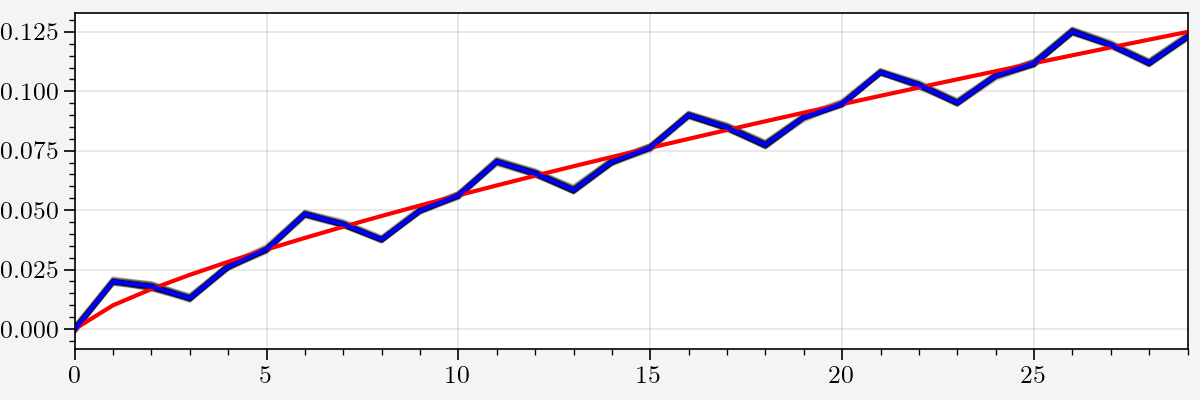

In [23]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
teffall = post_alphas_m[:, None] + post_deltas_m.reshape(-1, nr * nc)
plt.plot(teffall[:, np.random.choice(nr * nc, 100)], c="black", alpha=0.05)
plt.plot(teff, c="red")
plt.plot(post_alphas.T, c="blue", alpha=0.01)
plt.plot(post_alphas_m, c="blue")

<a list of 1 Line2D objects>

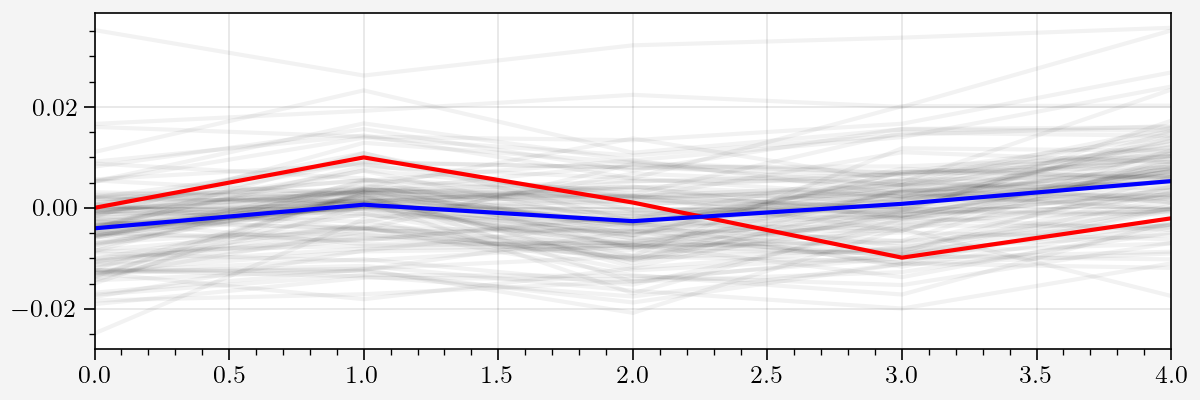

In [ ]:
# pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
# seffall = post_gammas_m.reshape(-1, nr * nc)
# plt.plot(seffall[:, np.random.choice(nr * nc, 100)], c="black", alpha=0.05)
# plt.plot(seff[:model.season], c="red")
# plt.plot(post_gammas_m.mean((1,2)), c="blue")

<a list of 1 Line2D objects>

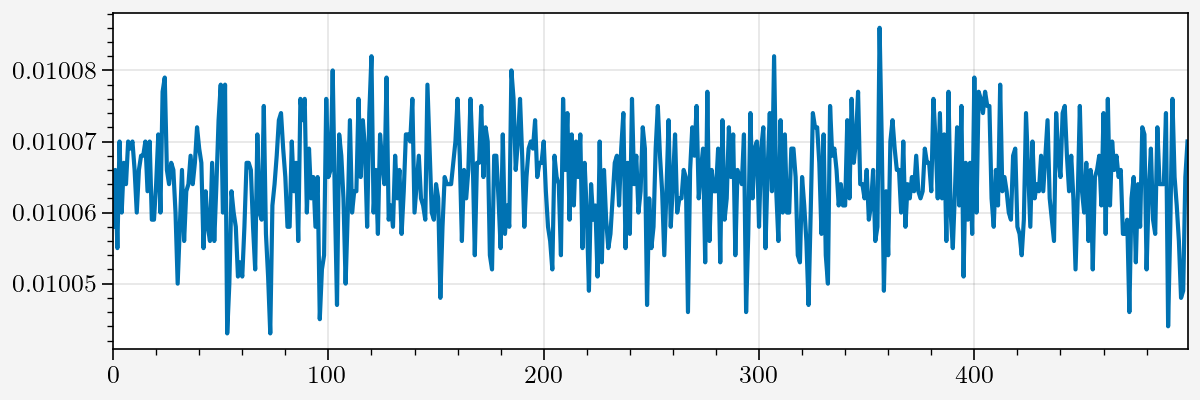

In [24]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
stdev = np.round(1.0 / np.sqrt(precs[(niters//2):]), 6)
plt.plot(stdev)

<a list of 2 Line2D objects>

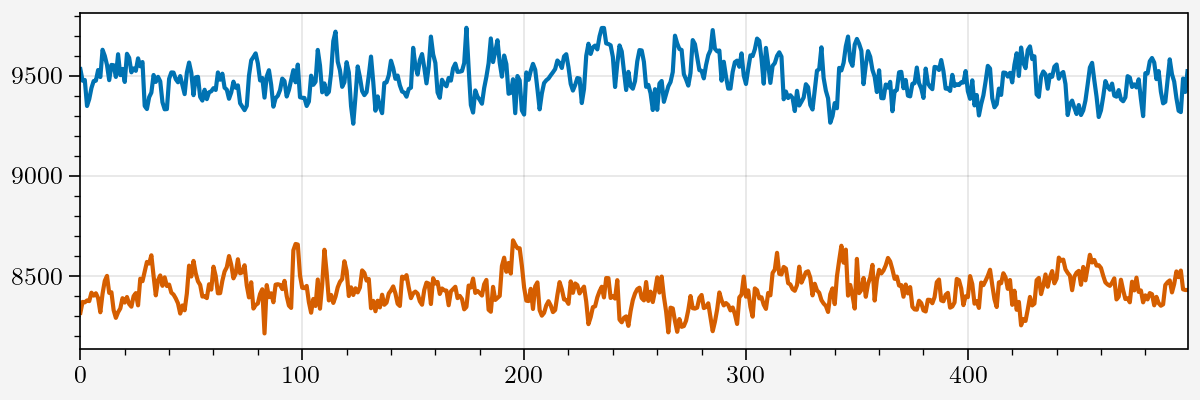

In [25]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
plt.plot(lams[(niters//2):])

<a list of 1 Line2D objects>

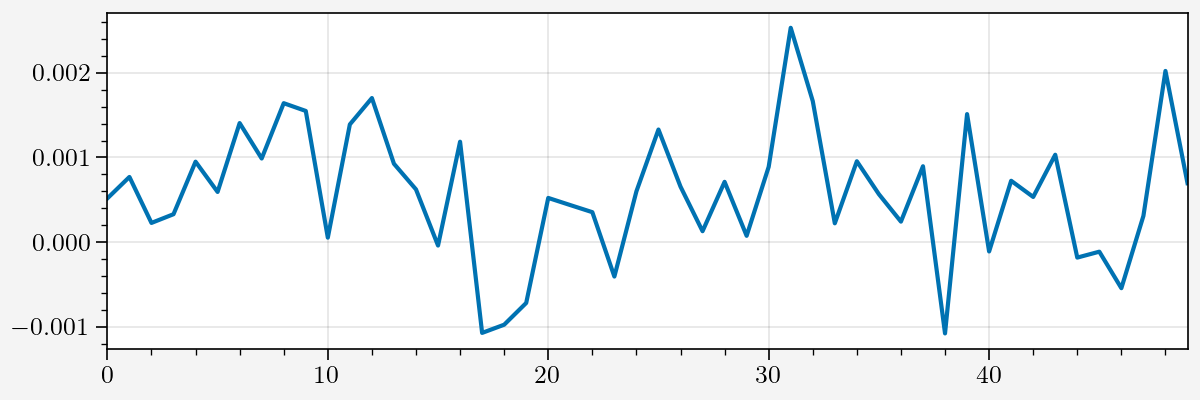

In [26]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
plt.plot(post_Mus[:, 0, 0, 0])

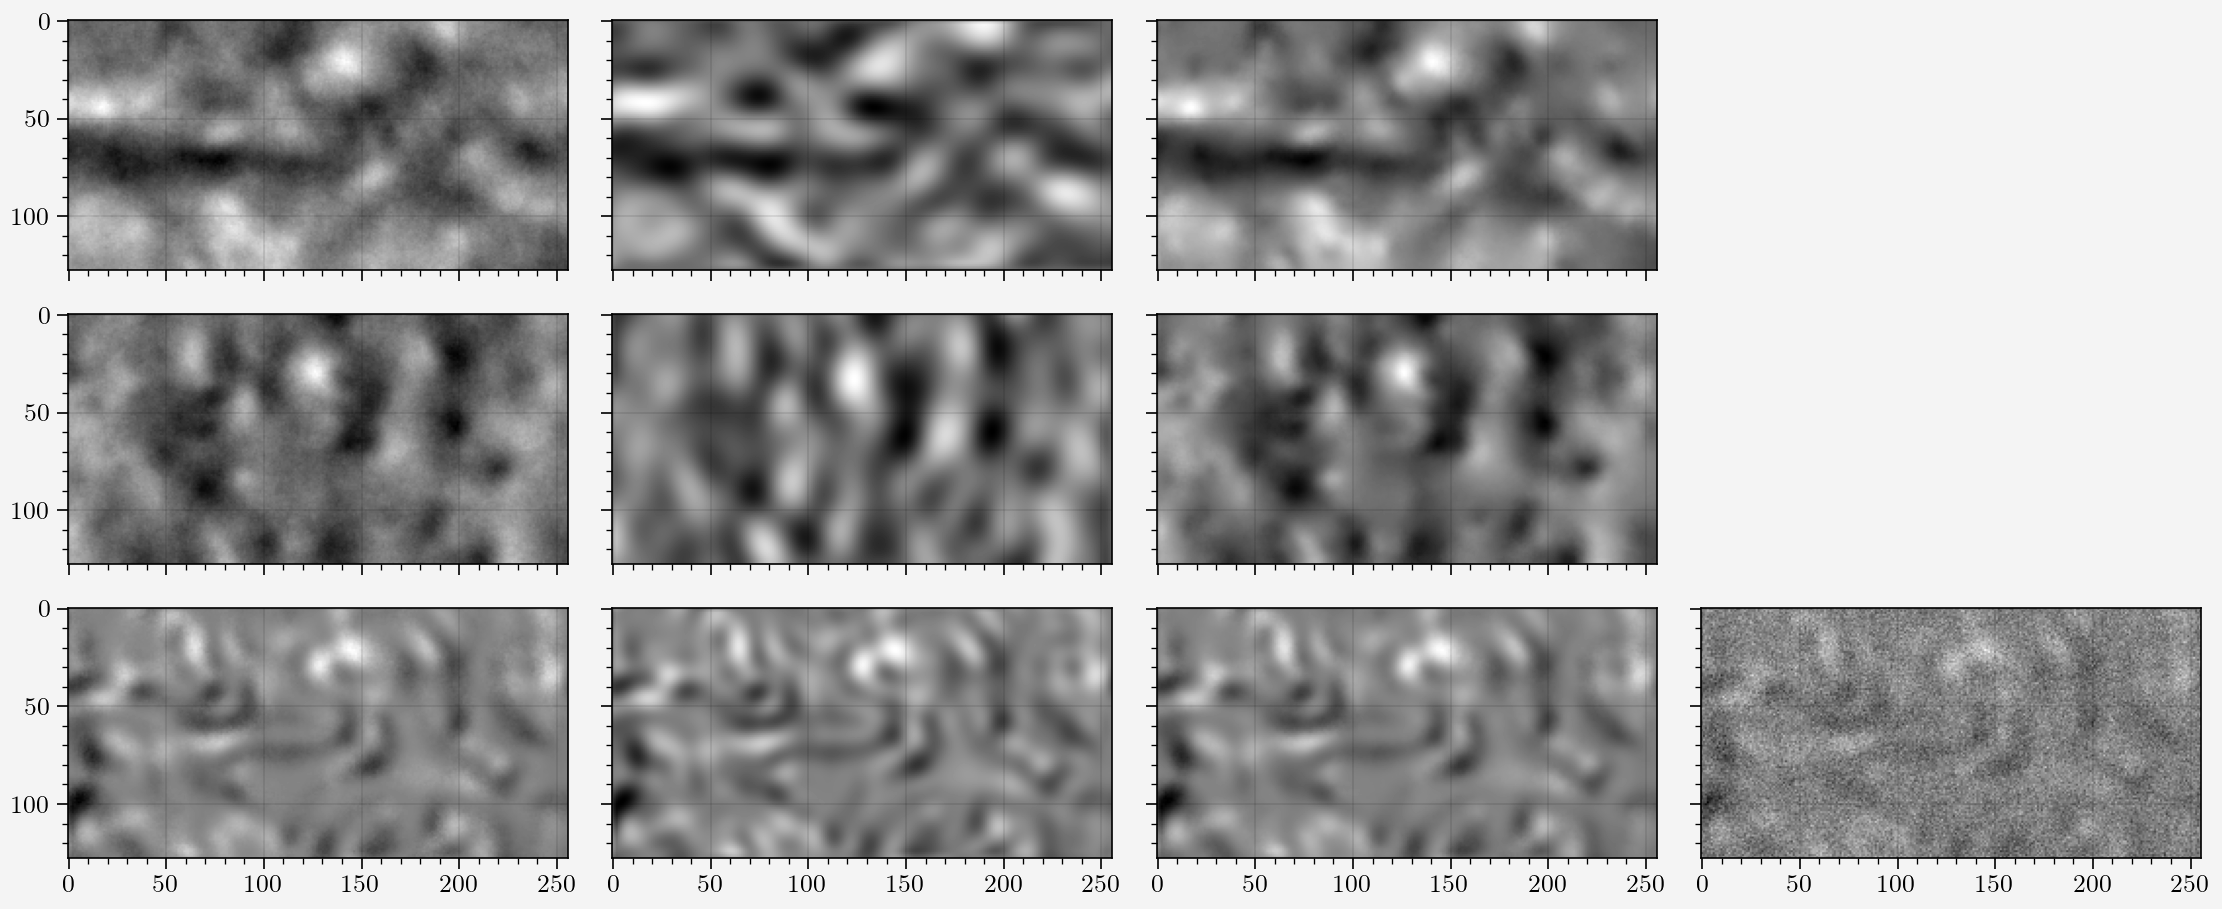

In [27]:
fig, ax = pplt.subplots([[1, 2, 7, 0], [3, 4, 8, 0], [5, 6, 9, 10]])

ax[0].imshow(model.beta[0], cmap='gray')
ax[1].imshow(beta[0], cmap='gray')
ax[2].imshow(model.beta[1], cmap='gray')
ax[3].imshow(beta[1], cmap='gray')
ax[4].imshow(model.Mu[-1], cmap='gray')
ax[5].imshow(Ytrue[-1], cmap='gray')
ax[6].imshow(post_betas_m[0], cmap='gray')
ax[7].imshow(post_betas_m[1], cmap='gray')
ax[8].imshow(post_Mus_m[-1], cmap='gray')
ax[9].imshow(Y[-1], cmap='gray')